# Case Study: Employee Attrition - K -means clustering to visualize the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn import metrics
import nbimporter
from Employee_Attrition_1 import display_classification_report,draw_cm,draw_roc_auc_curve

In [3]:
df_employee_detail = pd.read_excel('WA_Fn-UseC_-HR-Employee-Attrition.xlsx')

In [4]:
df_employee_detail.Attrition.value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

## Upsampling the minority count to balance the dataset

In [5]:
from sklearn.utils import resample
attr_yes = df_employee_detail[df_employee_detail['Attrition'] == 'Yes']
attr_no = df_employee_detail[df_employee_detail['Attrition'] == 'No']
attr_yes_upsampled = resample(attr_yes,replace = True, n_samples=1000)
new_df_employee = pd.concat([attr_no,attr_yes_upsampled])


In [6]:
from sklearn.utils import shuffle
new_df_employee = shuffle(new_df_employee)

## Encoding the categorical features and the target value. 1- Yes. 0-No.


In [7]:
X_features = ['Age','DailyRate','DistanceFromHome','HourlyRate', 'MonthlyIncome',
                'MonthlyRate','PercentSalaryHike', 'TotalWorkingYears','TrainingTimesLastYear',
                'YearsAtCompany', 'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager',
                'BusinessTravel','Department','Education','EducationField','EnvironmentSatisfaction','Gender',
                'JobInvolvement','JobLevel','JobRole','JobSatisfaction','MaritalStatus','NumCompaniesWorked',
                'OverTime','PerformanceRating','RelationshipSatisfaction','StockOptionLevel','WorkLifeBalance'
              ]

categorical_features = ['BusinessTravel','Department','Education','EducationField','EnvironmentSatisfaction','Gender',
                'JobInvolvement','JobLevel','JobRole','JobSatisfaction','MaritalStatus','NumCompaniesWorked',
                'OverTime','PerformanceRating','RelationshipSatisfaction','StockOptionLevel','WorkLifeBalance']

In [8]:
employee_encoded_df = pd.get_dummies(data=new_df_employee[X_features],
                                     columns=categorical_features,
                                     drop_first=True)

In [9]:
Y = new_df_employee.Attrition.map(lambda x: int(x=='Yes'))
X = employee_encoded_df

## Splitting the dataset into train and test set

In [10]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3, random_state=42)

## Building Gradient Boosting model

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

In [12]:
gbc_intial = GradientBoostingClassifier(n_estimators=100,max_depth=10)

In [13]:
gbc_intial.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

## Measuring accuracy of the model on test data

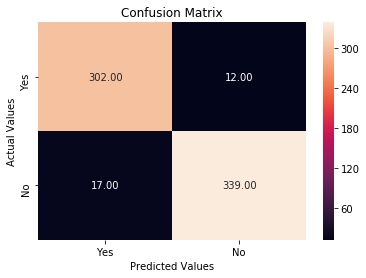

In [14]:
draw_cm(y_test,gbc_intial.predict(x_test))

In [15]:
display_classification_report(y_test,gbc_intial.predict(x_test))

             precision    recall  f1-score   support

          0       0.97      0.95      0.96       356
          1       0.95      0.96      0.95       314

avg / total       0.96      0.96      0.96       670



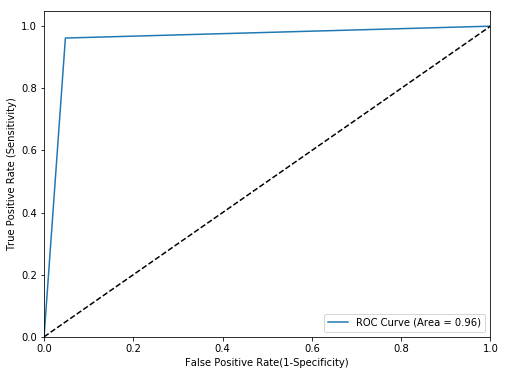

(array([0.        , 0.04775281, 1.        ]),
 array([0.        , 0.96178344, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [16]:
draw_roc_auc_curve(y_test,gbc_intial.predict(x_test))

## Building xgboost (eXtreme Gradient BOOSTing) model

In [17]:
from xgboost import XGBClassifier

In [18]:
xgb_initial = XGBClassifier()

In [19]:
xgb_initial.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

## Measuring accuracy of the model on test data

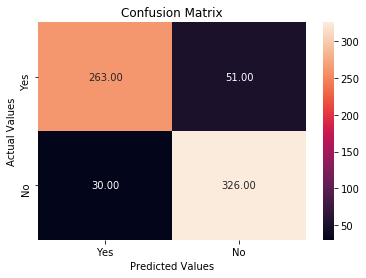

In [20]:
draw_cm(y_test,xgb_initial.predict(x_test))

In [21]:
display_classification_report(y_test,xgb_initial.predict(x_test))

             precision    recall  f1-score   support

          0       0.86      0.92      0.89       356
          1       0.90      0.84      0.87       314

avg / total       0.88      0.88      0.88       670



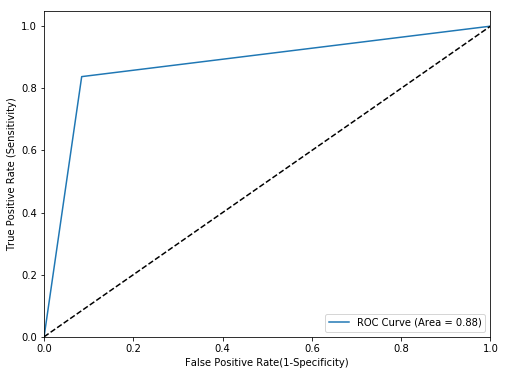

(array([0.        , 0.08426966, 1.        ]),
 array([0.        , 0.83757962, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [22]:
draw_roc_auc_curve(y_test,xgb_initial.predict(x_test))

## Hyperparameter tuning using GridSearchCV to find the best parameters in model building:

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
tuned_parameters = [{'learning_rate':[0.1,0.01],
                    'max_depth': range(2,5),
                    'n_estimators':[100,200]}]

In [25]:
xgb_final = GridSearchCV(estimator=XGBClassifier(),param_grid=tuned_parameters,scoring='roc_auc',cv=10,verbose=2)

In [26]:
xgb_final.fit(x_train,y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................
[CV] . learning_rate=0.1, max_depth=2, n_estimators=100, total=   1.2s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] . learning_rate=0.1, max_depth=2, n_estimators=100, total=   1.2s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................
[CV] . learning_rate=0.1, max_depth=2, n_estimators=100, total=   1.1s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................
[CV] . learning_rate=0.1, max_depth=2, n_estimators=100, total=   1.2s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................
[CV] . learning_rate=0.1, max_depth=2, n_estimators=100, total=   1.2s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................
[CV] . learning_rate=0.1, max_depth=2, n_estimators=100, total=   1.2s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................
[CV] . learning_rate=0.1, max_depth=2, n_estimators=100, total=   1.2s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................
[CV] . learning_rate=0.1, max_depth=2, n_estimators=100, total=   1.2s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................
[CV] .

[CV] . learning_rate=0.1, max_depth=4, n_estimators=200, total=   3.4s
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, total=   0.9s
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, total=   1.2s
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, total=   1.1s
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, total=   1.2s
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, total=   1.2s
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, total=   1.2s
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV]  

[CV]  learning_rate=0.01, max_depth=4, n_estimators=200, total=   4.8s
[CV] learning_rate=0.01, max_depth=4, n_estimators=200 ...............
[CV]  learning_rate=0.01, max_depth=4, n_estimators=200, total=   4.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=200 ...............
[CV]  learning_rate=0.01, max_depth=4, n_estimators=200, total=   4.0s


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  4.8min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'learning_rate': [0.1, 0.01], 'max_depth': range(2, 5), 'n_estimators': [100, 200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [27]:
xgb_final.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}

In [28]:
xgb_final.best_score_

0.9710389120841538

## Building the xgboost Classifier model again with the best optimal parameters

In [29]:
xgb_final_model = XGBClassifier(learning_rate=0.1,max_depth=4,n_estimators=200)

In [30]:
xgb_final_model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

## Accuracy on test data

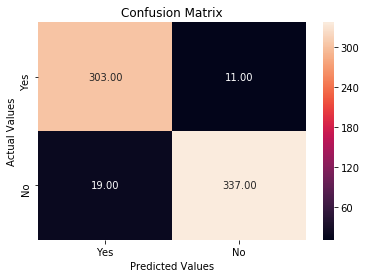

In [31]:
draw_cm(y_test,xgb_final_model.predict(x_test))

In [32]:
display_classification_report(y_test,xgb_final_model.predict(x_test))

             precision    recall  f1-score   support

          0       0.97      0.95      0.96       356
          1       0.94      0.96      0.95       314

avg / total       0.96      0.96      0.96       670



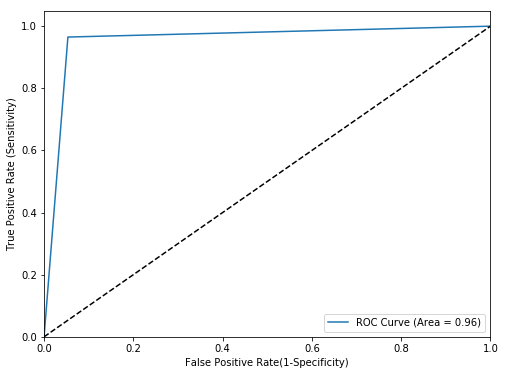

(array([0.        , 0.05337079, 1.        ]),
 array([0.        , 0.96496815, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [33]:
draw_roc_auc_curve(y_test,xgb_final_model.predict(x_test))

## Checking accuracy using k-fold cross-validation

In [34]:
print('Accuracy score without cross-validation {0}%'.format(np.round(metrics.accuracy_score(y_test,xgb_final_model.predict(x_test))*100,2 )))  #Accuracy without cross-validation

Accuracy score without cross-validation 95.52%


In [35]:
from sklearn.model_selection import cross_val_score

In [36]:
cv_scrores = cross_val_score(estimator=xgb_final_model,X=x_test,y=y_test,scoring='roc_auc',cv=10)

In [37]:
print('Accuracy score with cross-validation {0}%'.format(np.round((np.mean(cv_scrores)*100),2)))

Accuracy score with cross-validation 92.01%


# K-means clustering using important features found in previous notebook

In [ ]:
# 'MonthlyIncome','Age','OverTime_Yes','TotalWorkingYears','DistanceFromHome', 'HourlyRate','Attrition'

In [113]:
Y[Y == 1].index

Int64Index([ 744,  482,  122,  370,  102,  939, 1312,  732, 1438,  385,
            ...
             111,  666, 1162,  731,  663,  323,  368,  666, 1338,  706],
           dtype='int64', length=1000)

In [114]:
employee_churned_yes_df = pd.DataFrame()

In [115]:
employee_churned_yes_df

""


In [116]:
for i in Y[Y == 1].index:
    employee_churned_yes_df=employee_churned_yes_df.append(X.iloc[i])

In [117]:
employee_churned_yes_df.reset_index(drop=True,inplace=True)

In [118]:
employee_churned_yes_df = employee_churned_yes_df[['MonthlyIncome','Age',
                                                ]]

In [119]:
employee_churned_yes_df.head()

,MonthlyIncome,Age
0,9907.0,32.0
1,2166.0,40.0
2,3464.0,28.0
3,11904.0,59.0
4,4448.0,40.0


In [120]:
## Scaling the data

In [121]:
from sklearn.preprocessing import StandardScaler

In [123]:
scaler = StandardScaler()
scaled_employee_df = scaler.fit_transform(employee_churned_yes_df[['MonthlyIncome','Age'
                                                                   ]])

In [124]:
scaled_employee_df

array([[ 0.92295014, -0.44745212],
       [-0.81677457,  0.34961244],
       [-0.52505998, -0.8459844 ],
       ...,
       [-0.55113   , -0.34781905],
       [ 0.86226991, -0.54708519],
       [-0.81362819, -0.64671826]])

In [125]:
## Finding optimal number of clusters using Wlbow Curve Method

In [126]:
from sklearn.cluster import KMeans

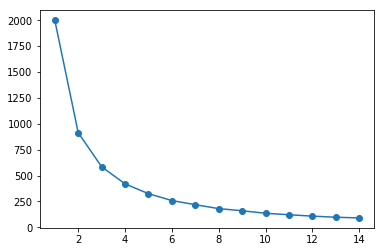

In [127]:
cluster_range = range(1,15)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans(num_clusters)
    clusters.fit(scaled_employee_df)
    cluster_errors.append(clusters.inertia_)
    
plt.figure(figsize=(6,4))
plt.plot(cluster_range,cluster_errors,marker = "o");

In [128]:
# K = 3 from graph

In [129]:
#Creating clusters

k=3
clusters = KMeans(k,random_state=42)
clusters.fit(scaled_employee_df)
employee_churned_yes_df['clusterid'] = clusters.labels_

In [130]:
employee_churned_yes_df['clusterid'].value_counts()

0    486
2    355
1    159
Name: clusterid, dtype: int64

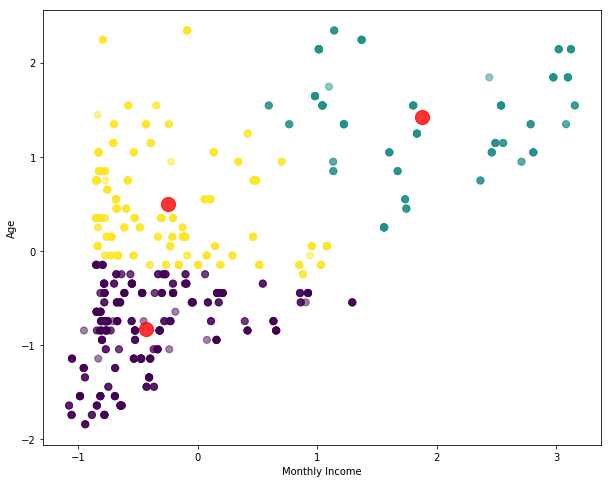

In [140]:
plt.figure(figsize=(10,8))
plt.scatter(scaled_employee_df[:, 0], scaled_employee_df[:, 1], c=clusters.labels_, s=50, cmap='viridis',alpha=0.5)

centers = clusters.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.8);
plt.xlabel('Monthly Income')
plt.ylabel('Age');